Notebook to test how to approach the short term persistence measurement
using flt files as stimulus and ima files as the images where to measure persistence


In [19]:
from astropy.io import fits
from stwcs import updatewcs
import glob, os, shutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip


%matplotlib notebook

In [20]:
#Setup the working directory and change into it

wdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/14016_data/Visit01/'
os.chdir(wdir)

<IPython.core.display.Javascript object>


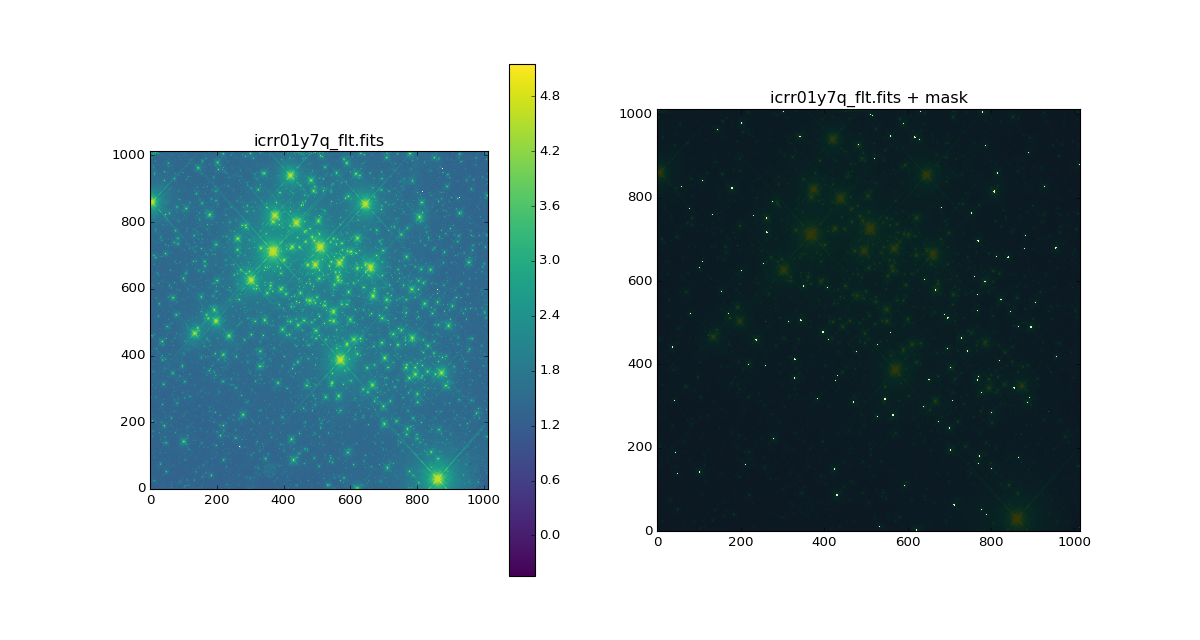

icrr01y7q_flt.fits F140W 21:32:57 0.0 0.0 352.939514 F140W
-15.6977


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10


In [39]:
# Print the exposure information for the stimulus image

sfltname = 'icrr01y7q_flt.fits'
pimaname = 'icrr01y8q_ima.fits'
pfltname = 'icrr01y8q_flt.fits'

sflt = fits.getdata(sfltname)

fig = plt.figure(figsize=(15,8))

sfhdr0 = fits.getheader(sfltname,0)
sfhdr1 = fits.getheader(sfltname,1)

print(sfltname, sfhdr0['FILTER'], sfhdr0['TIME-OBS'], sfhdr0['POSTARG1'], sfhdr0['POSTARG2'], sfhdr0['EXPTIME'], sfhdr0['FILTER'])
    
ax1 = fig.add_subplot(1,2,1)
c, low, upp = sigmaclip(sflt, 2.5,3)
mn = np.amin(c)
print(mn)
im = ax1.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax1.set_title(sfltname)
fig.colorbar(im, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax2.set_title(sfltname+' + mask')


In [45]:
#Select the region in the stimulus image that will be looked at in the IMA image 

mode = 'lev'
pflt = fits.getdata(pfltname)

msky = np.nanmean(sigmaclip(pflt,2.5,2.5)[0])
ssky = np.nanstd(sigmaclip(pflt,2.5,2.5)[0])

if (mode == 'cen'):
    xcen = 29
    ycen = 19
    rad = 2
    ix = np.arange(fhdr1['NAXIS1'])
    iy = np.arange(fhdr1['NAXIS2'])
    ixx,iyy = np.meshgrid(ix,iy)
    igood = (np.abs(ixx-xcen) < rad) & (np.abs(iyy-ycen) < rad)
elif (mode == 'lev'):
    lev_u = np.inf
    lev_d = 1e4
    igood = (sflt > lev_d) & (sflt < lev_u) & (pflt <msky+1*ssky) & (pflt >msky-1*ssky)

print('Number of selected pixels:',np.sum(igood))

#fig = plt.figure(figsize=(10,8))
#ax1 = fig.add_subplot(1,1,1)
ax2.imshow(igood,cmap='gray', interpolation='none',alpha=0.75,origin='lower')



Number of selected pixels: 410


In [46]:
#NSAMP

nsamp = fits.getheader(pfltname)['NSAMP']
pimahdu = fits.open(pimaname)
pflthdu = fits.open(pfltname)
sflthdu = fits.open(sfltname)


ramps = np.zeros([np.sum(igood),nsamp-1])
eramps = np.zeros([np.sum(igood),nsamp-1])
rfits = np.zeros(np.sum(igood))
sfits = np.zeros(np.sum(igood))
mfits = np.zeros(np.sum(igood))
nsky  = np.zeros(np.sum(igood))
ncsky  = np.zeros(np.sum(igood))


nramps = np.sum(igood)
print('Number of ramps',np.sum(igood))

skyrad_o = 12
skyrad_i = 3

times = np.zeros(nsamp-1)
xgrid,ygrid = np.meshgrid( np.arange(pflthdu[1].data.shape[0]) ,np.arange(pflthdu[1].data.shape[1]))

for i in range(nsamp-1):
    edt = pimahdu['ERR',i+1].data[5:-5,5:-5]
    eramps[:,i] = edt[igood]
    times[i] = pimahdu['TIME',i+1].header['PIXVALUE']
    dt = (pimahdu['SCI',i+1].data[5:-5,5:-5]*times[i] -  pimahdu['SCI',i+2].data[5:-5,5:-5]*pimahdu['TIME',i+2].header['PIXVALUE'])/(times[i]-pimahdu['TIME',i+2].header['PIXVALUE'])
    ramps[:,i] = dt[igood]

goodx = xgrid[igood]
goody = ygrid[igood]
    
for j in range(nramps):
    rfits[j] = pflthdu[1].data[igood][j]
    sfits[j] = sflthdu[1].data[igood][j]
    ix = goodx[j]
    iy = goody[j]
    
    dst = np.sqrt((xgrid-ix)**2 + (ygrid-iy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
#    msk = (np.fabs(xgrid-ix) < skyrad_o) & (np.fabs(ygrid-iy) < skyrad_o)
    skyarr = pflthdu[1].data[msk]
    
#    skyarr = pflthdu[1].data[ix-skyrad_o:ix+skyrad_o,iy-skyrad_o:iy+skyrad_o]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    mfits[j] = np.nanmean(cskyarr)
    nsky[j] = skyarr.size
    ncsky[j] = cskyarr.size
    
isort = np.argsort(sfits)[::-1]

sfits = sfits[isort]
rfits = rfits[isort]
mfits = mfits[isort]
nsky  = nsky[isort]
ncsky  = ncsky[isort]

ramps[:,:]  = ramps[isort,::-1]
eramps[:,:] = eramps[isort,::-1]
times = times[::-1]


Number of ramps 410


<IPython.core.display.Javascript object>


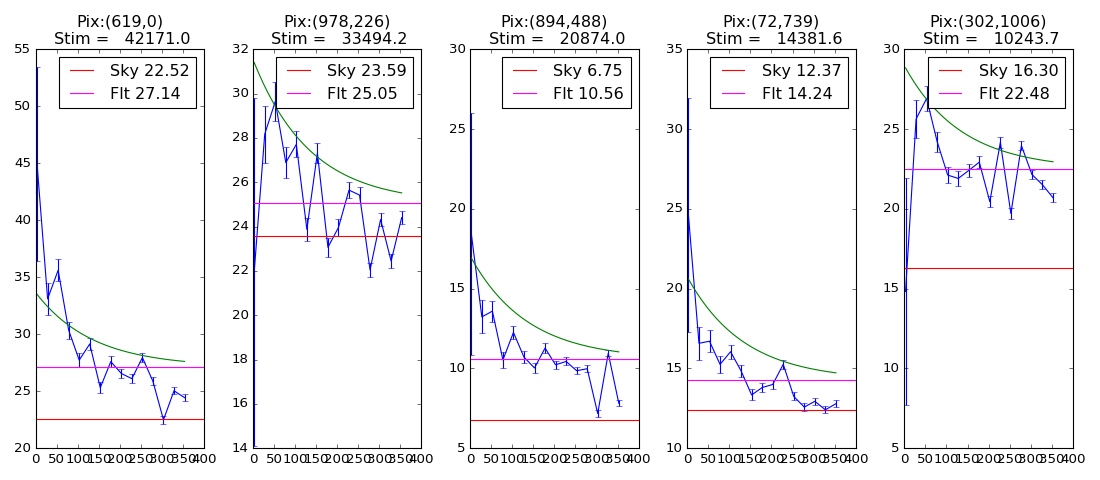

In [47]:
plot_every = 100
ppr = 5

nplots = (nramps+plot_every-1)//plot_every 
nrows = (nplots+ppr-1)//ppr

fig = plt.figure(figsize=(2.75*ppr,6*nrows))
deltat   = np.logspace(np.log10(times[0]+pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']),
                       np.log10(times[-1]+pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']),100)

ax = []
for j,aa in enumerate(range(0,nramps,plot_every)):

    ax.append(fig.add_subplot(nrows,ppr,j+1))
#    ax[-1].errorbar(times[:-1],ramps[aa,:-1],yerr=eramps[aa,:-1],c='r')
    ax[-1].errorbar(times,ramps[aa,:],yerr=eramps[aa,:])
    ax[-1].plot(deltat,6.5*np.exp(-deltat/135)+rfits[aa])
    ax[-1].axhline(mfits[aa],color='r',label='Sky'+'% .2f' %mfits[aa])
    ax[-1].axhline(rfits[aa],color='magenta',label='Flt'+'% .2f' %rfits[aa])
    ax[-1].legend()
    ax[-1].set_title('Pix:('+str(goodx[aa])+','+str(goody[aa])+')'+'\n Stim =  '+'% .1f' % sfits[aa])
#    ax[-1].set_yscale('log')
#    ax[-1].set_xscale('log')
    
    
plt.tight_layout()

<IPython.core.display.Javascript object>


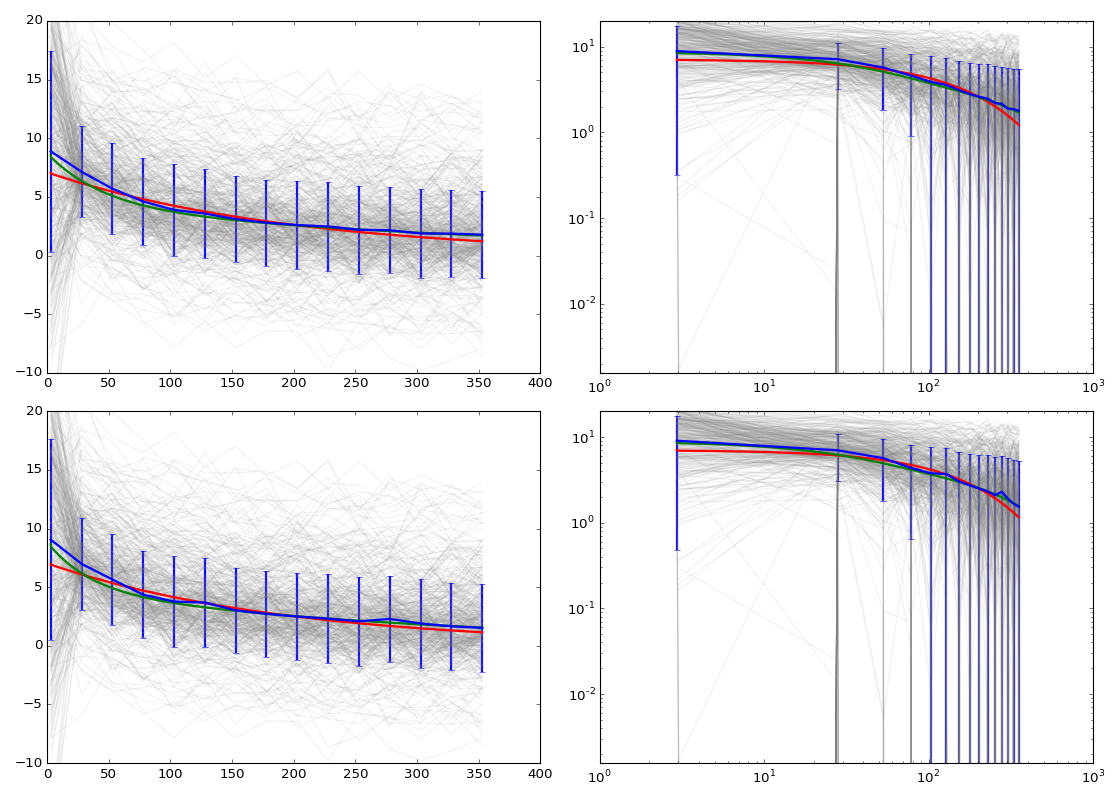

*********
1 Exp decay
[   7.53831439  196.26443418]
[   7.48432283  191.05763585]
[[  1.38388832e-01  -4.34943344e+00]
 [ -4.34943344e+00   2.21098181e+02]]
[[  1.48337082e-01  -4.50954511e+00]
 [ -4.50954511e+00   2.22593304e+02]]
*********
1 Exp decay, integrated
[   7.09401144  195.7008206 ]
[   7.02776549  190.69653316]
[[  1.19534873e-01  -4.09868377e+00]
 [ -4.09868377e+00   2.49388944e+02]]
[[  1.28845888e-01  -4.28906265e+00]
 [ -4.28906265e+00   2.54790943e+02]]
*********
2 Exp decay
[   3.59635852  489.17304425    5.76940717   61.41991519]
[   4.31198603  360.55549413    5.19950512   49.74167136]
[[  1.73719868e-01  -3.63936942e+01  -1.40051425e-01  -2.35167894e+00]
 [ -3.63936942e+01   7.79862780e+03   2.98925741e+01   4.77719762e+02]
 [ -1.40051425e-01   2.98925741e+01   1.30291742e-01   1.69506082e+00]
 [ -2.35167894e+00   4.77719762e+02   1.69506082e+00   3.56760382e+01]]
[[  4.74080242e-01  -4.98138545e+01  -3.62041504e-01  -6.24882454e+00]
 [ -4.98138545e+01   5.4252471

In [58]:
fig = plt.figure(figsize=(14,10))

toff = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']
#tmod   = np.linspace(times[0],times[-1],100)
#deltat = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'] + tmod
deltat   = np.logspace(np.log10(times[0]+toff),np.log10(times[-1]+toff),100)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

for aa in range(nramps):

    ax1.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)
    ax2.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)
    ax3.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)
    ax4.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)

mnp = np.zeros(nsamp-1)
mdp = np.zeros(nsamp-1)
sdp = np.zeros(nsamp-1)

for nn in range(nsamp-1):
    mnp[nn] = np.mean(ramps[:,nn]-mfits)
    mdp[nn] = np.median(ramps[:,nn]-mfits)
    sdp[nn] = np.std(ramps[:,nn]-mfits)
    

mnp = geometric_median(ramps-mfits[:,None], eps=1e-5)    
    
def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def intdec1(t,a1,t1):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td)
    
def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2

def intdec2(t,a1,t1,a2,t2):
    tu = t[1:]
    td = t[:-1]
    k1,k2  = -a1*t1, - a2*t2
    
    return k1*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) + k2*(np.exp(-tu/t2)-np.exp(-td/t2))/(tu-td)


from scipy.optimize import curve_fit

popt1_md, pcov1_md = curve_fit(decay1, times+toff,mdp,sigma=sdp,p0=[4,100])
popt1_mn, pcov1_mn = curve_fit(decay1, times+toff,mnp,sigma=sdp,p0=[4,100])

popt1_md_i, pcov1_md_i = curve_fit(intdec1, np.append([0],times)+toff,mdp,sigma=sdp,p0=[4,100])
popt1_mn_i, pcov1_mn_i = curve_fit(intdec1, np.append([0],times)+toff,mnp,sigma=sdp,p0=[4,100])

popt2_md, pcov2_md = curve_fit(decay2, times+toff,mdp,sigma=sdp,p0=[4,100,2,10])
popt2_mn, pcov2_mn = curve_fit(decay2, times+toff,mnp,sigma=sdp,p0=[4,100,2,10])

popt2_md_i, pcov2_md_i = curve_fit(intdec2, np.append([0],times)+toff,mdp,sigma=sdp,p0=[4,100,2,10])
popt2_mn_i, pcov2_mn_i = curve_fit(intdec2, np.append([0],times)+toff,mnp,sigma=sdp,p0=[4,100,2,10])

print('*********')
print('1 Exp decay')
print(popt1_mn)
print(popt1_md)
print(pcov1_mn)
print(pcov1_md)
print('*********')
print('1 Exp decay, integrated')
print(popt1_mn_i)
print(popt1_md_i)
print(pcov1_mn_i)
print(pcov1_md_i)
print('*********')
print('2 Exp decay')
print(popt2_mn)
print(popt2_md)
print(pcov2_mn)
print(pcov2_md)
print('*********')
print('2 Exp decay integrated')
print(popt2_mn_i)
print(popt2_md_i)
print(pcov2_mn_i)
print(pcov2_md_i)

#ax1.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
#ax2.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
#ax3.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)
#ax4.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)

ax1.plot(deltat,intdec1(np.append([0],deltat),*popt1_mn_i),c='r',linewidth=2)
ax2.plot(deltat,intdec1(np.append([0],deltat),*popt1_mn_i),c='r',linewidth=2)
ax3.plot(deltat,intdec1(np.append([0],deltat),*popt1_md_i),c='r',linewidth=2)
ax4.plot(deltat,intdec1(np.append([0],deltat),*popt1_md_i),c='r',linewidth=2)

#ax1.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
#ax2.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
#ax3.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)
#ax4.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)

ax1.plot(deltat,intdec2(np.append([0],deltat),*popt2_mn_i),c='g',linewidth=2)
ax2.plot(deltat,intdec2(np.append([0],deltat),*popt2_mn_i),c='g',linewidth=2)
ax3.plot(deltat,intdec2(np.append([0],deltat),*popt2_md_i),c='g',linewidth=2)
ax4.plot(deltat,intdec2(np.append([0],deltat),*popt2_md_i),c='g',linewidth=2)



ax1.errorbar(times+toff,mnp,yerr=sdp,c='b',linewidth=2)
ax2.errorbar(times+toff,mnp,yerr=sdp,c='b',linewidth=2)
ax3.errorbar(times+toff,mdp,yerr=sdp,c='b',linewidth=2)
ax4.errorbar(times+toff,mdp,yerr=sdp,c='b',linewidth=2)

    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xscale('log')

ax1.set_ylim(-10,20)
ax2.set_ylim(-10,20)
ax3.set_ylim(-10,20)
ax4.set_ylim(-10,20)
    
plt.tight_layout()

In [54]:
import numpy as np
from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1



In [59]:
mnp

array([ 8.88563432,  7.14152522,  5.70177344,  4.60784201,  3.88960642,
        3.57880668,  3.10948352,  2.80103117,  2.5988528 ,  2.47857126,
        2.1939583 ,  2.15600482,  1.88425963,  1.86886795,  1.78022162])

In [60]:
mdp

array([ 9.05310678,  6.99042225,  5.65726376,  4.3584156 ,  3.77342987,
        3.69277716,  3.02512646,  2.72330046,  2.50039339,  2.31833696,
        2.09156418,  2.29008675,  1.90659189,  1.66398048,  1.5357585 ])